# garbage_classifier

This notebook classifies website text snippets into useful or not (i.e., garbage) using transfer learning starting from an existing hugging face model
* Get a model checkpoint for an encoder model 
* Use reinforcement learning to apply the model on a new classification problem (EAGER website data) with limited new trained data
* Apply new head of model to full EAGER corpus to come up with mixes of models
* Metrics and model registered through a combination of comet.ml and tensorboard 

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 14 17:34:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install and import libraries

In [2]:
COMET_PROJECT_NAME = "eager-garbage-classifier"

In [3]:
# check environment
import sys
IN_COLAB = 'google.colab' in sys.modules
print (IN_COLAB)

True


In [4]:
# colab file system setup 
if IN_COLAB: 
    !git clone https://github.com/euphonic/EAGER.git
    !pwd
    !mkdir /content/logs

fatal: destination path 'EAGER' already exists and is not an empty directory.
/content
mkdir: cannot create directory ‘/content/logs’: File exists


In [39]:
# mount google drive if in colab
drive_path = '/content/drive/'

if IN_COLAB:  
    from google.colab import drive
    drive.mount(drive_path, force_remount=True)

Mounted at /content/drive/


In [7]:
# install huggingface and other modules if in colab
if IN_COLAB: 
    !pip install transformers
    !pip install datasets
    !pip install python-dotenv
    !pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 101 kB 14.6 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.0 MB/s 
     |████████████████████████████████| 212 kB 68.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.7 MB/s 
     |████████████████████████████████| 140 kB 76.4 MB/s 
     |████████████████████████████████| 127 kB 52.8 MB/s 
     |████████████████████████████████| 144 kB 41.6 MB/s 
     |████████████████████████████████| 271 kB 56.7 MB/s 
     |███████████

In [6]:
from comet_ml import Experiment
from comet_ml.api import API
from dotenv import load_dotenv

# setup comet_ml experiment
if IN_COLAB: 
    # read env file from Google drive 
    env_file = drive_path + 'MyDrive/raaste-config/.env'
    comet_config_file = drive_path + 'MyDrive/raaste-config/.comet.config'
    load_dotenv(env_file)

In [7]:
# ml libraries
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, \
  AutoConfig, TFBertForSequenceClassification
from datasets import Dataset
import datasets
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import pandas as pd

# other
import numpy as np
import gzip
import tarfile
import datetime
import os 

In [54]:
if IN_COLAB: 
    !pip uninstall -y comet_ml
    !pip install comet_ml

Found existing installation: comet-ml 3.31.6
Uninstalling comet-ml-3.31.6:
  Successfully uninstalled comet-ml-3.31.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached comet_ml-3.31.6-py2.py3-none-any.whl (372 kB)


In [8]:
# load tensorboard 
%load_ext tensorboard

## Garbage classifier
keep test == 1, discard == 0

In [9]:
# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [40]:
firm_file_location = '/content/EAGER/data/modeling/garbage/garbage_classifier_input.csv'
input_df = pd.read_csv(firm_file_location)
print(input_df.shape)

(5624, 2)


In [11]:
# inspect duplicates manually 

# dup_df = input_df[input_df.duplicated('sample_text', keep=False)]
# tmp_out_dir = '/content/tmp/'
# os.makedirs(tmp_out_dir, exist_ok=True)  
# dup_df.to_csv(tmp_out_dir + '/dup_df.csv', ',')

In [41]:
# remove duplicates and nulls
non_dup_df = input_df[~input_df.duplicated('sample_text', keep="first")]
print (non_dup_df.shape) 
non_null_df = non_dup_df[~ non_dup_df['sample_text'].isnull() ]
print (non_null_df.shape)

(4740, 2)
(4740, 2)


In [42]:
dataset = Dataset.from_pandas(non_null_df, split='train')
dataset.cast_column("of_interest", datasets.Value('int8'))

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['sample_text', 'of_interest', '__index_level_0__'],
    num_rows: 4740
})

In [90]:
# 85% train, 15% test + validation
train_test_dataset = dataset.train_test_split(test_size=0.15)
# Split the 20% test + valid in half test, half valid
test_valid_dataset = train_test_dataset['test'].train_test_split(test_size=0.3)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = datasets.DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid_dataset['test'],
    'valid': test_valid_dataset['train']})

In [91]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__'],
        num_rows: 4029
    })
    test: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__'],
        num_rows: 214
    })
    valid: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__'],
        num_rows: 497
    })
})

In [92]:
def tokenize_function(x):
  return tokenizer(x["sample_text"], truncation=True, max_length=100)

In [93]:
tokenized_dataset = train_test_valid_dataset.map(tokenize_function, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [94]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4029
    })
    test: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 214
    })
    valid: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 497
    })
})

In [95]:
samples = tokenized_dataset["train"].to_dict()
samples = {k: v for k, v in samples.items() if k not in ["__index_level_0__", "sample_text"]}
for k, v in samples.items(): 
  print (k, v[0:5])

of_interest [0, 0, 1, 0, 0]
input_ids [[101, 16408, 102], [101, 2188, 102], [101, 2224, 11412, 4454, 2000, 9699, 6695, 2005, 2047, 6599, 9199, 1010, 5335, 17034, 1010, 1998, 3623, 6975, 5056, 1012, 102], [101, 2994, 1999, 3543, 2007, 2149, 999, 102], [101, 9394, 3343, 29655, 1526, 102]]
token_type_ids [[0, 0, 0], [0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
attention_mask [[1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]


In [96]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=100, return_tensors="tf")

In [97]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'attention_mask': TensorShape([4029, 100]),
 'input_ids': TensorShape([4029, 100]),
 'of_interest': TensorShape([4029]),
 'token_type_ids': TensorShape([4029, 100])}

In [120]:
# config
config = AutoConfig.from_pretrained(checkpoint)
config.num_labels=1
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2
config.hidden_size = 128
config.intermediate_size = 512
config.num_hidden_layers = 4
config.num_attention_heads = 4
print (type(config))

<class 'transformers.models.bert.configuration_bert.BertConfig'>


In [122]:
num_epochs = 50
batch_sizes = [128]
model_name = COMET_PROJECT_NAME.replace ('-', '_')

for bs in batch_sizes: 
  # read config file from git repo 
  experiment = Experiment(project_name=COMET_PROJECT_NAME)
  with experiment.train():
    experiment.log_parameter("batch_size", bs)

  # model
  model = TFAutoModelForSequenceClassification.from_config(config)
  print (type(model))

  print ('batch_size', bs)

  tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="of_interest",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=bs,
  )

  tf_validation_dataset = tokenized_dataset["valid"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="of_interest",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=bs,
  )

  # The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
  # by the total number of epochs
  num_train_steps = len(tf_train_dataset) * num_epochs
  lr_scheduler = PolynomialDecay(
      initial_learning_rate=5e-5, end_learning_rate=0, decay_steps=num_train_steps
  )

  opt = Adam(learning_rate=lr_scheduler, beta_1=0.9, beta_2=0.999)

  log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)    

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

  loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True, gamma=2.0, label_smoothing=0.2) # gamma = 0 is equivalent to binary cross entropy
  model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

  model.fit(tf_train_dataset, validation_data=tf_validation_dataset, 
        epochs=num_epochs, callbacks=[tensorboard_callback, early_stopping_callback])
  
  # save model to disk -- can be added to for loop above

  model_save_path = '/content/models/' + model_name + "_" + str(bs)
  print (model_save_path)
  model.save_pretrained(model_save_path)
  experiment.log_model(name=model_name, file_or_folder=model_save_path)
  
  experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Experiment is live on comet.ml https://www.comet.com/euphonic/eager-garbage-classifier/05303e5460eb40ae8735bfce98497642

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


<class 'transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification'>
batch_size 128
Epoch 1/50
32/32 [==============================] - 17s 173ms/step - loss: 0.1690 - accuracy: 0.6006 - val_loss: 0.1675 - val_accuracy: 0.5996
Epoch 2/50
32/32 [==============================] - 4s 135ms/step - loss: 0.1637 - accuracy: 0.6006 - val_loss: 0.1540 - val_accuracy: 0.5996
Epoch 3/50
32/32 [==============================] - 4s 136ms/step - loss: 0.1325 - accuracy: 0.6513 - val_loss: 0.1151 - val_accuracy: 0.8109
Epoch 4/50
32/32 [==============================] - 4s 129ms/step - loss: 0.1054 - accuracy: 0.8354 - val_loss: 0.1138 - val_accuracy: 0.8169
Epoch 5/50
32/32 [==============================] - 4s 128ms/step - loss: 0.0981 - accuracy: 0.8439 - val_loss: 0.1040 - val_accuracy: 0.8249
Epoch 6/50
32/32 [==============================] - 4s 135ms/step - loss: 0.0874 - accuracy: 0.8622 - val_loss: 0.0983 - val_accuracy: 0.8531
Epoch 7/50
32/32 [==============================

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/euphonic/eager-garbage-classifier/05303e5460eb40ae8735bfce98497642
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [17]                : (0.6006453037261963, 0.978406548500061)
COMET INFO:     batch_accuracy [68]          : (0.5703125, 0.9783266186714172)
COMET INFO:     batch_loss [68]              : (0.01938755437731743, 0.1738334596157074)
COMET INFO:     epoch_duration [17]          : (4.066425703000277, 17.26286866100054)
COMET INFO:     loss [17]                    : (0.026136504486203194, 0.1689690351486206)
COMET INFO:     val_accuracy [17]            : (0.5995975732803345, 0.863179087638855)
COMET INFO:     val_loss [17]                : (0.09651057422161102, 0.17102529108524323)
COMET INFO:     validate_batch_accuracy

## Register model

In [82]:
best_run = 'euphonic/' + COMET_PROJECT_NAME + '/classical_cinema_2878'
version = "1.0.2"
api = API()
api_exp = api.get(best_run)
api_exp.register_model(model_name, version=version)

COMET INFO: Successfully registered 'eager-garbage-classifier', version '1.0.2' in workspace 'euphonic'


{'registryModelId': 'dyXSwgVHtuYcesXa63lRU7TUh',
 'registryModelItemId': '4B5kJJsPrrMDLAjDizOLjCFgW'}

## Make predictions
Write results out to file for manual DQ

In [83]:
best_run = 'euphonic/' + COMET_PROJECT_NAME + '/classical_cinema_2878'
version = "1.0.2" # need to set manually for now
api = API()
api.download_registry_model("euphonic", COMET_PROJECT_NAME, version,
                            output_path="/content/registered_models/", expand=True)

COMET INFO: Downloading registry model 'eager-garbage-classifier', version '1.0.2', stage None from workspace 'euphonic'...
COMET INFO: Unzipping model to '/content/registered_models' ...
COMET INFO: done!


In [85]:
# optional retrieve model from registry
local_model_dir = 'eager_garbage_classifier_128' # need to set manually for now
model = TFBertForSequenceClassification.from_pretrained ('/content/registered_models/' + local_model_dir)

Some layers from the model checkpoint at /content/registered_models/eager_garbage_classifier_128 were not used when initializing TFBertForSequenceClassification: ['dropout_231']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/registered_models/eager_garbage_classifier_128.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training

In [130]:
np.random.seed(2015)
data = []
for i in range(5):
    data.append(dict(zip(np.random.choice(10, replace=False, size=5),
                         np.random.randint(10, size=5))))

data

[{0: 6, 3: 8, 4: 5, 7: 7, 8: 0},
 {1: 9, 2: 6, 4: 2, 6: 1, 9: 2},
 {1: 2, 2: 2, 3: 1, 4: 2, 6: 1},
 {0: 6, 2: 6, 4: 4, 5: 4, 6: 0},
 {1: 9, 3: 9, 5: 7, 6: 1, 7: 9}]

In [141]:
# open file dir
company_file_dir = '/content/EAGER/data/orgs/parsed_page_output'
data_for_df = []
for filename in os.listdir(company_file_dir):
  if filename.endswith('.txt'):
    with open( os.path.join(company_file_dir, filename) ) as file_h:
      print ('Working on ' + filename)
      co_text = [line for line in file_h]
      co_id = np.repeat (filename, len(co_text))
      co_index = np.arange (0, len(co_text))
      # print ('\tNumber of text elements: ' + str(len(co_text))) 
      # print (co_text)
      # co_df = pd.DataFrame(co_text, columns=['sample_text'])
      tokens = tokenizer(co_text, padding=True, truncation=True, return_tensors="tf")
      # print (tokens)
      output = model(**tokens)
      # print ('\tNumber of output logit elements: ' + str(len(output.logits))) 
      print (output.logits.shape)
      preds = tf.round(tf.nn.sigmoid(output.logits))
      s_logit = pd.Series(output.logits.numpy().flatten())
      s_preds = pd.Series(preds.numpy().flatten())
      # keep_text = remove_garbage (co_df) # string return type 

      data_for_df.append (dict(zip(co_id, co_index, co_text, s_logit, s_preds)))
    break 


Working on Chevron Phillips Chemical Company LP.txt
(1770, 1)


ValueError: ignored

In [ ]:
co_id

In [138]:
df = pd.DataFrame(data_for_df)

count    1770.000000
mean       -0.527774
std         1.942056
min        -2.158271
25%        -2.152323
50%        -2.070858
75%         2.017398
max         2.110805
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


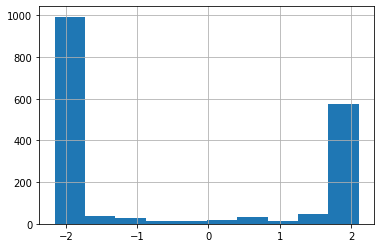

In [92]:
print (s_logit.describe())
print (s_logit.hist())

count    1770.000000
mean        0.385311
std         0.486806
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


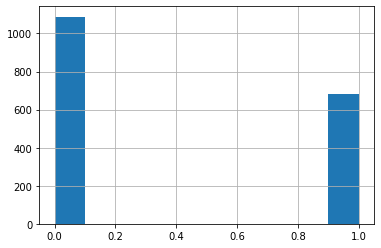

In [95]:
print (s_preds.describe())
print (s_preds.hist())